In [1]:
import pysabr
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# data ranges to generate training data

# S_min = 0.005
# S_max = 0.07
# S_Ks = np.linspace(S_min/S_max, S_max/S_max, num=10)
# Ts = np.linspace(0.5, 20., num=10)
# ds = np.linspace(0.0, 0.03, num=5)

# V_atms = np.linspace(0.001, 0.02, num=3) # lognormal: 0.001 - 0.02, normal: .1 1.5
# betas = np.linspace(0.1, 0.7, num=3)
# rhos = np.linspace(-0.4, 0.4, num=3)
# volvols = np.linspace(0.0001, 0.5, num=3)


In [3]:
# test_sabr = pysabr.Hagan2002LognormalSABR(0.03, 0.0001, 1., 0.5, 0.9999, 0.0001, 0.0001)
# print(test_sabr.lognormal_vol(0.03)) # normal_vol / F ~ atm log normal vol

In [29]:
def ln_vol_to_n_vol(ln_vol, f, K): # B64
    return ln_vol * (f-K)/(np.log(f/K)) * (1- (ln_vol ** 2) / 24)

# original range: 0.1 - 1.5, what units?
print(ln_vol_to_n_vol(0.1, 0.03, 0.035) / 0.03) # ln vol: 10%; ln_vol  * f ~ n_vol
print(ln_vol_to_n_vol(1.5, 0.03, 0.035) / 0.03) # ln vol: 150%

0.1080742701938853
1.4697470050335588


In [4]:
def data_gen_sabr(ranges, mode): # mode: ln or n
    print(f'mode: {mode}')
    start = time.time()
    Ss = ranges['Ss']
    Ts = ranges['Ts']
    V_atms = ranges['V_atms']
    betas = ranges['betas']
    rhos = ranges['rhos']
    volvols = ranges['volvols']
    ds = ranges['ds']
    Ks = ranges['Ks']

    sabr_processes = [pysabr.Hagan2002LognormalSABR(S, d, T, V_atm, beta, rho, volvol) if mode=='ln' \
                      else pysabr.Hagan2002NormalSABR(S, d, T, V_atm, beta, rho, volvol) \
                      for S in Ss \
                      for T in Ts \
                      for V_atm in V_atms \
                      for beta in betas \
                      for rho in rhos \
                      for volvol in volvols \
                      for d in ds
                     ]

    vols = np.reshape([sabr.lognormal_vol(k) if mode=='ln' else sabr.normal_vol(k) \
                       for sabr in sabr_processes \
                       for k in Ks], \
                       (Ss.shape[0], Ts.shape[0], V_atms.shape[0], betas.shape[0], rhos.shape[0], \
                        volvols.shape[0], ds.shape[0], Ks.shape[0])\
                     )

    end = time.time()
    print(f'compute vols time: {end - start}')
    names = ["S", "T", "V_atm", "Beta", "Rho", "Volvol", "Displacement", "K"]
    multiindex = pd.MultiIndex.from_product([range(i) for i in vols.shape],
                                            names=names
                                           )
    full_df = pd.DataFrame(vols.reshape((-1,1)), index=multiindex, columns=[f"{mode}_vol"])

    print(full_df.describe())
    print(full_df.loc[(full_df<0).values])
    return vols

In [5]:
def plot_vols(vols, ranges): # after squeeze, only betas remain
    fig = plt.figure(figsize=(15,15))
    X, Y = np.meshgrid(ranges['Ts'], ranges['Ks'], indexing='ij')
    for beta_i in range(ranges['betas'].shape[0]):
        surface = vols[:, beta_i, :]
        ax = fig.add_subplot(1, ranges['betas'].shape[0], beta_i+1, projection='3d')
        surf = ax.plot_surface(X, Y, Z=surface, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0,
                                antialiased=False)
        ax.set_zlim(np.min(surface)*1.1, np.max(surface)*1.1)
        ax.set_title(f"beta: {ranges['betas'][beta_i]}")
        fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()
        
        
        
#      for s_i in range(ranges['Ss'].shape[0]):
#         for sigma_i in range(ranges['V_atms'].shape[0]):
            
#                 for rho_i in range(ranges['rhos'].shape[0]):
#                     for vv_i in range(ranges['volvols'].shape[0]):
#                         for d_i in range(ranges['ds'].shape[0]):
                            


In [6]:
# testing ranges:
# S_min = 0.005
# S_max = 0.07
# S_Ks = np.linspace(S_min/S_max, S_max/S_max, num=20)

Ss = np.array([0.035])
Ks = np.linspace(0.005, 0.07, num=100)
Ts = np.linspace(0.5, 20., num=50)

V_atm_n = np.array([0.001]) # confirm magnitude
betas = np.array([0.1, 0.7])
rhos = np.array([-0.4])
volvols = np.array([0.5])
ds = np.array([0.01])

In [7]:
# normal:
n_ranges = {'Ss': Ss,
             'Ts': Ts,
             'V_atms': V_atm_n,
             'betas': betas,
             'rhos': rhos,
             'volvols': volvols,
             'ds': ds,             
             'Ks': Ks,
            }
    
n_res = data_gen_sabr(n_ranges, 'n')

mode: n
compute vols time: 0.3797450065612793
              n_vol
count  10000.000000
mean       0.003091
std        0.001251
min        0.000938
25%        0.002034
50%        0.003136
75%        0.004144
max        0.005829
Empty DataFrame
Columns: [n_vol]
Index: []


(50, 2, 100)


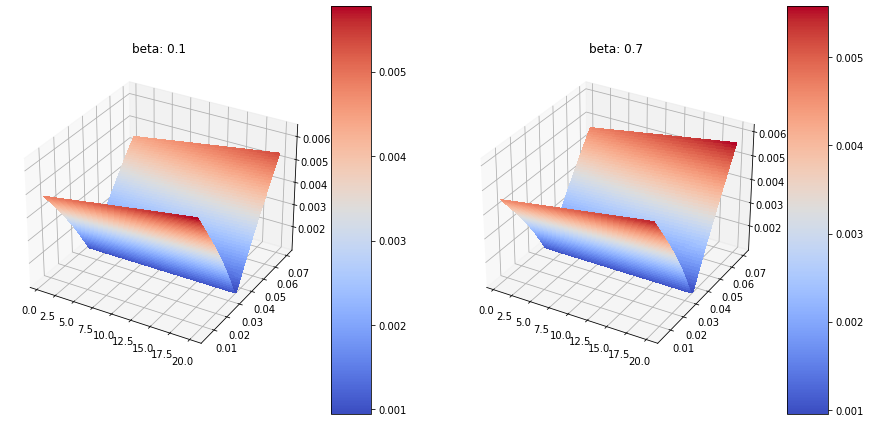

In [8]:
# normal:
print(n_res.squeeze().shape)

plot_vols(n_res.squeeze(), n_ranges)

In [9]:
# lognormal:
V_atm_ln = np.array([0.01])

ln_ranges = {'Ss': Ss,
             'Ts': Ts,
             'V_atms': V_atm_n,
             'betas': betas,
             'rhos': rhos,
             'volvols': volvols,
             'ds': ds,
             'Ks': Ks,
            }
    
ln_res = data_gen_sabr(ln_ranges, 'ln')

mode: ln
compute vols time: 7.83925199508667
             ln_vol
count  10000.000000
mean       0.072312
std        0.039874
min        0.020621
25%        0.043368
50%        0.064445
75%        0.085714
max        0.206136
Empty DataFrame
Columns: [ln_vol]
Index: []


(50, 2, 100)


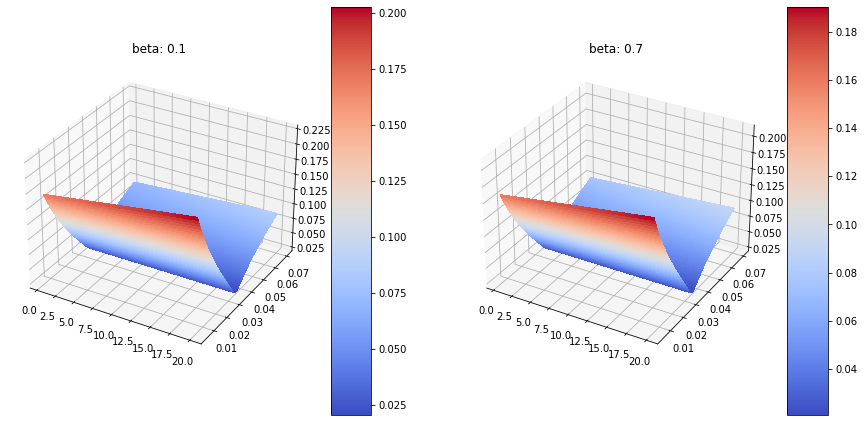

In [10]:
# lognormal:
print(ln_res.squeeze().shape)
plot_vols(ln_res.squeeze(), ln_ranges)

In [11]:
# pysabr.Hagan2002LognormalSABR(0.005, 0, 1, 0.1, 0.0001, -0.4, 0.0001).lognormal_vol(0.07)

(50, 2, 100)


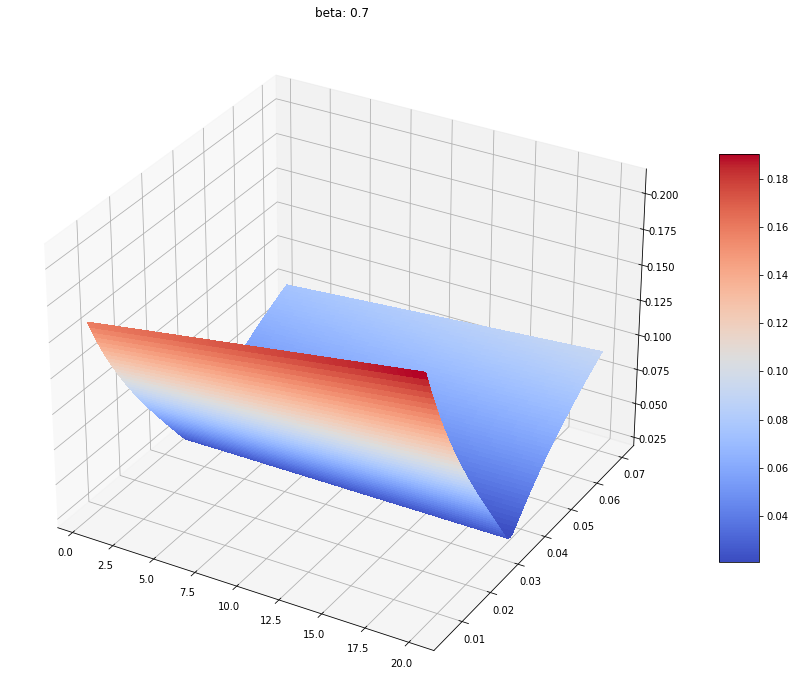

In [12]:
print(ln_res.squeeze().shape)

fig = plt.figure(figsize=(15,15))
X, Y = np.meshgrid(ln_ranges['Ts'], ln_ranges['Ks'], indexing='ij')

surface = ln_res.squeeze()[:, 1, :]
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z=surface, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0,
                        antialiased=False)
ax.set_zlim(np.min(surface)*1.1, np.max(surface)*1.1)
ax.set_title(f"beta: {0.7}")
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


In [13]:
# data_path = "data/"
# np.save(data_path + "debug_sample_lognormal_vol.npy", vols)